In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load and prepare data

In [73]:
df = pd.read_csv('data/train.csv')

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 41 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   UniqueID                             233154 non-null  int64  
 1   disbursed_amount                     233154 non-null  int64  
 2   asset_cost                           233154 non-null  int64  
 3   ltv                                  233154 non-null  float64
 4   branch_id                            233154 non-null  int64  
 5   supplier_id                          233154 non-null  int64  
 6   manufacturer_id                      233154 non-null  int64  
 7   Current_pincode_ID                   233154 non-null  int64  
 8   Date.of.Birth                        233154 non-null  object 
 9   Employment.Type                      225493 non-null  object 
 10  DisbursalDate                        233154 non-null  object 
 11  State_ID     

We are dropping the columns which have no context (ID columns), no variability (MobileNo_Avl_Flag) and are outdated (DisbursalDate).

In [75]:
df=df.drop(['UniqueID', 'branch_id','supplier_id', 'Current_pincode_ID','State_ID', 'Employee_code_ID', 'MobileNo_Avl_Flag', 'DisbursalDate'],axis=1)

In [76]:
df.isna().sum()

disbursed_amount                          0
asset_cost                                0
ltv                                       0
manufacturer_id                           0
Date.of.Birth                             0
Employment.Type                        7661
Aadhar_flag                               0
PAN_flag                                  0
VoterID_flag                              0
Driving_flag                              0
Passport_flag                             0
PERFORM_CNS.SCORE                         0
PERFORM_CNS.SCORE.DESCRIPTION             0
PRI.NO.OF.ACCTS                           0
PRI.ACTIVE.ACCTS                          0
PRI.OVERDUE.ACCTS                         0
PRI.CURRENT.BALANCE                       0
PRI.SANCTIONED.AMOUNT                     0
PRI.DISBURSED.AMOUNT                      0
SEC.NO.OF.ACCTS                           0
SEC.ACTIVE.ACCTS                          0
SEC.OVERDUE.ACCTS                         0
SEC.CURRENT.BALANCE             

In [77]:
df['Employment.Type'].value_counts()

Self employed    127635
Salaried          97858
Name: Employment.Type, dtype: int64

Replacing na values with most frequent one.

In [78]:
df['Employment.Type'] = df['Employment.Type'].fillna('Self employed')

# Feature engineering

In [79]:
df['PERFORM_CNS.SCORE.DESCRIPTION'].unique()

array(['No Bureau History Available', 'I-Medium Risk', 'L-Very High Risk',
       'A-Very Low Risk',
       'Not Scored: Not Enough Info available on the customer',
       'D-Very Low Risk', 'M-Very High Risk', 'B-Very Low Risk',
       'C-Very Low Risk', 'E-Low Risk', 'H-Medium Risk', 'F-Low Risk',
       'K-High Risk',
       'Not Scored: No Activity seen on the customer (Inactive)',
       'Not Scored: Sufficient History Not Available',
       'Not Scored: No Updates available in last 36 months', 'G-Low Risk',
       'J-High Risk', 'Not Scored: Only a Guarantor',
       'Not Scored: More than 50 active Accounts found'], dtype=object)

Creating variable Credit Risk from the grade in the string and maping it to numerical values.

In [80]:
def credit_risk(df):
    d=[]
    for i in df:
        p = i.split("-")
        if len(p) == 1:
            d.append('unknown')
        else:
            d.append(p[0])

    return d

sub_risk = {'unknown':-1, 'A':13, 'B':12, 'C':11,'D':10,'E':9,'F':8,'G':7,'H':6,'I':5,'J':4,'K':3, 'L':2,'M':1}
employment_map = {'Self employed':0, 'Salaried':1,np.nan:2}

df.loc[:,'credit_risk_grade']  = credit_risk(df["PERFORM_CNS.SCORE.DESCRIPTION"])
df.loc[:,'Credit Risk'] = df['credit_risk_grade'].apply(lambda x: sub_risk[x])

df.loc[:,'Employment Type'] = df['Employment.Type'].apply(lambda x: employment_map[x])

df=df.drop(['PERFORM_CNS.SCORE.DESCRIPTION', 'credit_risk_grade','Employment.Type'],axis=1)

Creating Age variable from Date of birth.

In [81]:
from datetime import date
year = date.today().year

df['Date.of.Birth']= pd.to_datetime(df['Date.of.Birth'])
ageArr = []
for x in df['Date.of.Birth']:
  badAge = year-int(str(x)[:4])
  age = badAge if badAge >= 0 else badAge+100
  ageArr.append(age)
  
df['Age'] = ageArr

In [82]:
df=df.drop(['Date.of.Birth'],axis=1)

In [83]:
def duration(dur):
  yrs=int(dur.split(' ')[0].replace('yrs',''))
  mon=int(dur.split(' ')[1].replace('mon',''))
  return yrs*12+mon

df['AVERAGE.ACCT.AGE']=df['AVERAGE.ACCT.AGE'].apply(duration)
df['CREDIT.HISTORY.LENGTH']=df['CREDIT.HISTORY.LENGTH'].apply(duration)

In [84]:
df['Missing Features'] = (df == 0).astype(int).sum(axis=1)

When we look at people who have a class value of 0 - we have those who have a value of 0 because they don't actually have a credit history, that is, we don't even have most of the data for them, and those who have a credit history, but they haven't defaulted and that's why we have 0. We introduce this attribute in order to helped the model differentiate those two groups of people.

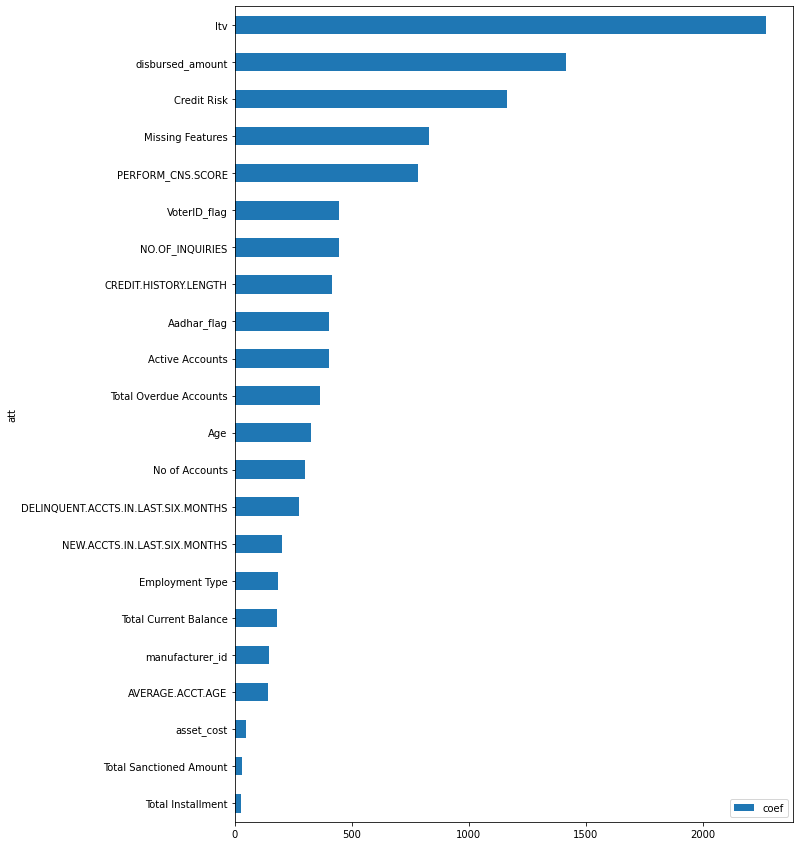

In [132]:
X=df.drop('loan_default',axis=1)
y=df['loan_default']

from sklearn.feature_selection import SelectKBest,f_classif

selection=SelectKBest(k=10, score_func=f_classif)
selection.fit(X,y)
selection.get_support()

coefs=pd.DataFrame({'att':X.columns,'coef':f_classif(X,y)[0]}).sort_values(by='coef',ascending=True)
_ = coefs.plot.barh(x='att',y='coef',figsize=(10,15))

We can see that all of the secondary account data are bad predictors, so we will then combine them together with the primary account information.

In [86]:
df.loc[:,'No of Accounts'] = df['PRI.NO.OF.ACCTS'] + df['SEC.NO.OF.ACCTS']
df.loc[:,'Active Accounts'] = df['PRI.ACTIVE.ACCTS'] + df['SEC.ACTIVE.ACCTS']
df.loc[:,'Total Overdue Accounts'] =df['PRI.OVERDUE.ACCTS'] + df['SEC.OVERDUE.ACCTS']
df.loc[:,'Total Current Balance'] = df['PRI.CURRENT.BALANCE'] + df['SEC.CURRENT.BALANCE']
df.loc[:,'Total Sanctioned Amount'] = df['PRI.SANCTIONED.AMOUNT'] + df['SEC.SANCTIONED.AMOUNT']
df.loc[:,'Total Disbursed Amount'] = df['PRI.DISBURSED.AMOUNT'] + df['SEC.DISBURSED.AMOUNT']
df.loc[:,'Total Installment'] = df['PRIMARY.INSTAL.AMT'] + df['SEC.INSTAL.AMT']

In [87]:
df=df.drop(['PRI.NO.OF.ACCTS','SEC.NO.OF.ACCTS','PRI.ACTIVE.ACCTS','SEC.ACTIVE.ACCTS',
            'PRI.OVERDUE.ACCTS','SEC.OVERDUE.ACCTS','PRI.CURRENT.BALANCE', 'SEC.CURRENT.BALANCE',
            'PRI.SANCTIONED.AMOUNT','SEC.SANCTIONED.AMOUNT','PRI.DISBURSED.AMOUNT','SEC.DISBURSED.AMOUNT',
            'PRIMARY.INSTAL.AMT','SEC.INSTAL.AMT','Passport_flag','Driving_flag','PAN_flag'],axis=1)

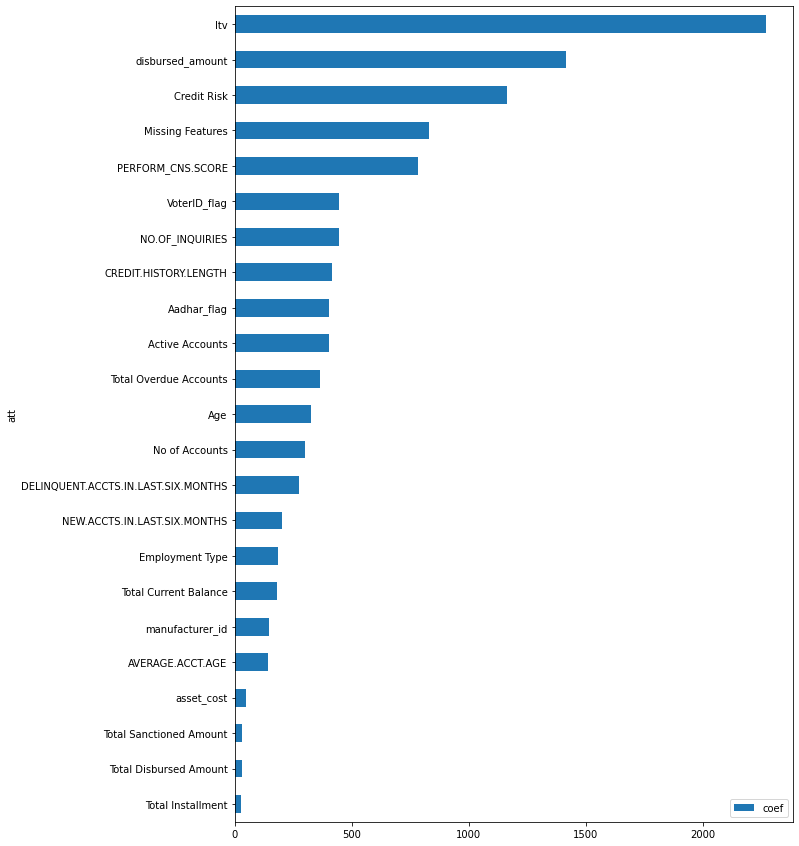

In [88]:
X=df.drop('loan_default',axis=1)
y=df['loan_default']
coefs=pd.DataFrame({'att':X.columns,'coef':f_classif(X,y)[0]}).sort_values(by='coef',ascending=True)
_ = coefs.plot.barh(x='att',y='coef',figsize=(10,15))

Droping Total Disbursed Amount beacuse disbursed_amount is a better predictor.

In [89]:
df = df.drop(['Total Disbursed Amount'],axis=1)

In [90]:
nums=['asset_cost', 'ltv','PERFORM_CNS.SCORE',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES','No of Accounts',
       'Total Overdue Accounts', 'Total Current Balance', 'Total Sanctioned Amount', 'Total Installment','Age']

In [91]:
from sklearn.preprocessing import  RobustScaler
rob_scaler = RobustScaler()

df[nums] = rob_scaler.fit_transform(df[nums])

# Training and optimizing models

In [92]:
from sklearn.model_selection import train_test_split
X=df.drop('loan_default',axis=1)
y=df['loan_default']
y=y.astype('int')
X, X_test, y, y_test = train_test_split(X, y, test_size=0.3, random_state=2022)

model_dr=DecisionTreeClassifier(max_depth=3)
model_nb=GaussianNB()
model_lr = LogisticRegression(solver='liblinear',C=0.1)

In [93]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_curve)

In [94]:
modelnb=model_nb.fit(X,y)
accuracy_score(y_test,modelnb.predict(X_test))

0.7802907915993538

In [97]:
tree1 = DecisionTreeClassifier()
tree1.fit(X,y)
accuracy_score(y_test,tree1.predict(X_test))

0.9057715127167713

In [98]:
tree1 = DecisionTreeClassifier()
print(cross_val_score(tree1, X,y, cv=10, scoring='accuracy').mean())

0.9023142628857805


We use grid search to find optimal model parameters

In [99]:
from sklearn.model_selection import GridSearchCV

tree = DecisionTreeClassifier()
parameters = {'max_features': [15, 16, 17], 'min_samples_leaf': [21, 23, 25, 27, 29, 31],'max_depth': [23,25,27,29,31]} 
grid = GridSearchCV(tree, parameters, cv=5, scoring='accuracy') 
grid.fit(X,y)
print('Best param: ', grid.best_params_) 

Best param:  {'max_depth': 25, 'max_features': 17, 'min_samples_leaf': 21}


In [116]:
tree1 = DecisionTreeClassifier(max_features=17, min_samples_leaf=21, max_depth=25)
modeltr1=tree1.fit(X,y)
accuracy_score(y_test,tree1.predict(X_test))

0.9090740131814088

In [117]:
from sklearn.ensemble import BaggingClassifier

model_bagging = BaggingClassifier(base_estimator=tree1, n_estimators=10)
model_bagging.fit(X,y)
predictionBagging = model_bagging.predict(X_test)
accuracy_score(y_test,predictionBagging)

0.9193103349679043

In [118]:
from sklearn.ensemble import AdaBoostClassifier
model_boost = AdaBoostClassifier(base_estimator=modeltr1, n_estimators=10, learning_rate=0.5)
model_boost.fit(X,y)
accuracy_score(y_test,model_boost.predict(X_test))

0.9027978326447167

In [119]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=5)
forest.fit(X,y)
accuracy_score(y_test,forest.predict(X_test))

0.8761633808454973

In [120]:
prec = precision_score(y_test, predictionBagging)
rec = recall_score(y_test, predictionBagging)
f1 = f1_score(y_test, predictionBagging)
f'Additional metrics: {np.round(prec * 100, 2)}% precision, {np.round(rec * 100, 2)}% recall i {np.round(f1 * 100, 2)}% F1'

'Additional metrics: 79.33% precision, 84.71% recall i 81.93% F1'

# Prediction optimization

Bagging clasifier gives us the best results, we will now optimize predictions for our problem.
Using the cost matrix, we will determine the cost of our model's mistakes. It is better if we don't approve a loan for a customer who would repay it, than if we approve a loan for a customer who wouldn't.

In [121]:
confusion_matrix(y_true=y_test, y_pred=predictionBagging)

array([[51507,  3334],
       [ 2310, 12796]], dtype=int64)

In [122]:
costs = np.array([[0, 1], [5, 0]])

In [123]:
confusion_matrix(y_test,predictionBagging)* costs

array([[    0,  3334],
       [11550,     0]], dtype=int64)

In [124]:
(confusion_matrix(y_test,predictionBagging)* costs).sum()

14884

In [125]:
probas = model_bagging.predict_proba(X_test)
pred_proba = probas[:, 1]

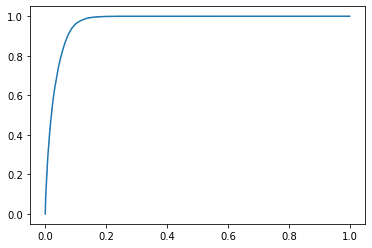

In [126]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, pred_proba) # za y i za predict probabilities i sacuvamo u ova tri parametara
plt.plot(fpr, tpr)
plt.show()

In [127]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, pred_proba)

0.969629495181348

In [128]:
predictions =model_bagging.predict_proba(X_test)[:, 1] >= 0.2
confusion_matrix(y_test, predictions)

array([[47725,  7116],
       [  213, 14893]], dtype=int64)

In [129]:
confusion_matrix(y_test,predictions)* costs

array([[   0, 7116],
       [1065,    0]], dtype=int64)

In [130]:
(confusion_matrix(y_test,predictions)* costs).sum()

8181